In [1]:
import pandas as pd
import numpy as np
import pandas as pd 
import re
import os
from datetime import datetime
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud ,STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import word2vec
import plotly.tools as tls
import plotly.plotly as py
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()
sns.set()
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
p = "YlGnBu"
p2 = "YlGn"
p3 = "Greys"


In [3]:
df = pd.read_csv("./input/nyc-jobs.csv")

In [4]:
df.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,87990,DEPARTMENT OF BUSINESS SERV.,Internal,1,Account Manager,CONTRACT REVIEWER (OFFICE OF L,40563,1,NaN,NaN,...,"Salary range for this position is: $42,405 - $...",NaN,NaN,NaN,NaN,New York City residency is generally required ...,2011-06-24T00:00:00.000,NaN,2011-06-24T00:00:00.000,2019-07-30T00:00:00.000
1,97899,DEPARTMENT OF BUSINESS SERV.,Internal,1,"EXECUTIVE DIRECTOR, BUSINESS DEVELOPMENT",ADMINISTRATIVE BUSINESS PROMOT,10009,M3,NaN,F,...,NaN,"In addition to applying through this website, ...",NaN,NaN,NaN,New York City residency is generally required ...,2012-01-26T00:00:00.000,NaN,2012-01-26T00:00:00.000,2019-07-30T00:00:00.000
2,132292,NYC HOUSING AUTHORITY,External,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-07-30T00:00:00.000
3,132292,NYC HOUSING AUTHORITY,Internal,52,Maintenance Worker - Technical Services-Heatin...,MAINTENANCE WORKER,90698,0,Maintenance & Operations,F,...,1. A Motor Vehicle Driverâ€™s License valid i...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirements.,2013-10-24T00:00:00.000,NaN,2013-12-12T00:00:00.000,2019-07-30T00:00:00.000
4,133921,NYC HOUSING AUTHORITY,Internal,50,Temporary Painter,PAINTER,91830,0,Maintenance & Operations,F,...,SPECIAL NOTE: 1. This is a temporary assig...,"Click the ""Apply Now"" button.",NaN,NaN,NaN,NYCHA has no residency requirement.,2014-01-09T00:00:00.000,NaN,2014-01-08T00:00:00.000,2019-07-30T00:00:00.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 28 columns):
Job ID                           3123 non-null int64
Agency                           3123 non-null object
Posting Type                     3123 non-null object
# Of Positions                   3123 non-null int64
Business Title                   3123 non-null object
Civil Service Title              3123 non-null object
Title Code No                    3123 non-null object
Level                            3123 non-null object
Job Category                     3121 non-null object
Full-Time/Part-Time indicator    2854 non-null object
Salary Range From                3123 non-null float64
Salary Range To                  3123 non-null float64
Salary Frequency                 3123 non-null object
Work Location                    3123 non-null object
Division/Work Unit               3123 non-null object
Job Description                  3123 non-null object
Minimum Qual Requirements    

# Data cleaning & Feature engineering

In [6]:
#helper functions
def plot_wordcloud(text):
    wordcloud = WordCloud(background_color="white", width=1024, height=720).generate(text)
    plt.clf()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

def parse_categories(x):
    l = x.replace('&', ',').split(',')
    l = [x.strip().rstrip()for x in l]
    key_categories.extend(l)

def parse_keywords(x, l):
    x = x.lower()
    tokens = nltk.word_tokenize(x)
    stop_words = set(stopwords.words('english'))
    token_l = [w for w in tokens if not w in stop_words and w.isalpha()]
    l.extend(token_l)

def preferred_skills(x):
    kwl=[]
    df[df.job_category == x].preferred_skills.dropna().apply(parse_keywords, l=kwl)
    kwl = pd.Series(kwl)
    return kwl.value_counts()[:20]

In [7]:
df.drop(['Recruitment Contact', 'Post Until'], axis=1, inplace=True)
df.columns = ['id', 'agency', 'posting_type', 'number_of_positions', 'business_title', 'civil_service_title', 'title_code_number', 'level', 'job_category', 'full-time/part-time', 'salary_range_low', 'salary_range_high', 'salary_frequency', 'work_location', 'work_unit', 'job_description', 'minimum_requirements', 'preferred_skills', 'additional_info', 'to_apply', 'shift', 'work_location_1', 'residency_requirement', 'posting_date', 'posting_updated', 'process_date' ]

In [8]:
df.job_category.value_counts()

Engineering, Architecture, & Planning                                                                                                            520
Technology, Data & Innovation                                                                                                                    369
Public Safety, Inspections, & Enforcement                                                                                                        219
Legal Affairs                                                                                                                                    206
Health                                                                                                                                           185
                                                                                                                                                ... 
Administration & Human Resources Constituent Services & Community Programs Policy, Research & Analysis    

In [9]:
key_categories = []
df.job_category.dropna().apply(parse_categories)
key_categories = pd.Series(key_categories)
key_categories = key_categories[key_categories!='']
popular_categories = key_categories.value_counts().iloc[:25]
print(key_categories)
print(popular_categories)

0         Maintenance
1          Operations
2         Maintenance
3          Operations
4         Maintenance
             ...     
10491    Architecture
10493        Planning
10494     Engineering
10495    Architecture
10497        Planning
Length: 8977, dtype: object
Architecture              754
Engineering               729
Planning                  527
Data                      477
Inspections               457
Enforcement               447
Research                  444
Innovation                418
Technology                406
Analysis                  378
Accounting                310
Administration            261
Finance                   240
Constituent Services      239
Public Safety             219
Legal Affairs             206
Maintenance               203
Building Operations       186
Procurement               185
Health                    185
Community Programs        167
Policy                    153
Human Resources           119
Planning Public Safety     96
Communicat

# Full time or Part time?

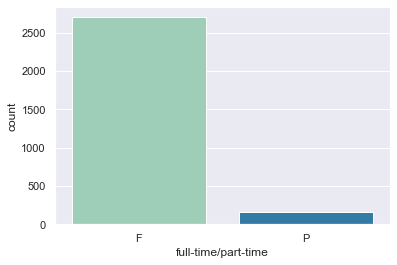

In [10]:
sns.countplot(x='full-time/part-time', data=df, palette=p)

# Salart frequency

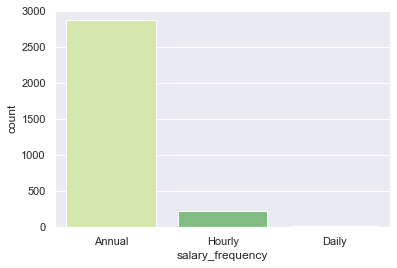

In [11]:
sns.countplot(x='salary_frequency', data=df, palette=p2)

# Most in-demand job categories

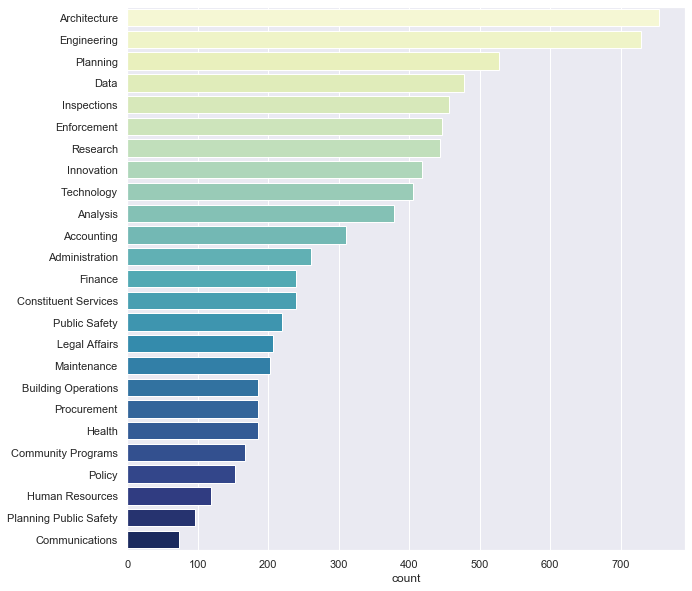

In [12]:
plt.figure(figsize=(10,10))
sns.countplot(y=key_categories, order=popular_categories.index, palette=p)

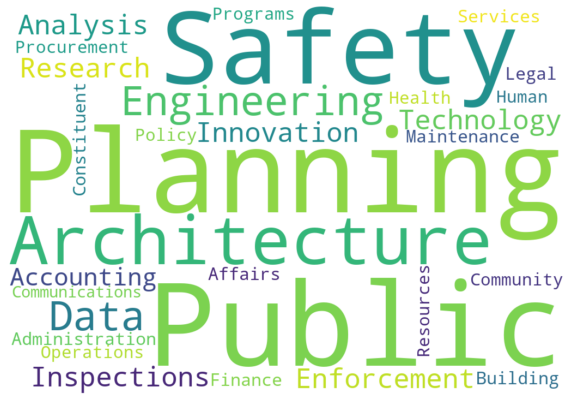

Architecture Engineering Planning Data Inspections Enforcement Research Innovation Technology Analysis Accounting Administration Finance Constituent Services Public Safety Legal Affairs Maintenance Building Operations Procurement Health Community Programs Policy Human Resources Planning Public Safety Communications


In [13]:
plt.figure(figsize=(10, 8))
plot_wordcloud(' '.join(popular_categories.index.tolist()))
print(' '.join(popular_categories.index.tolist()))

# Most popular job titles

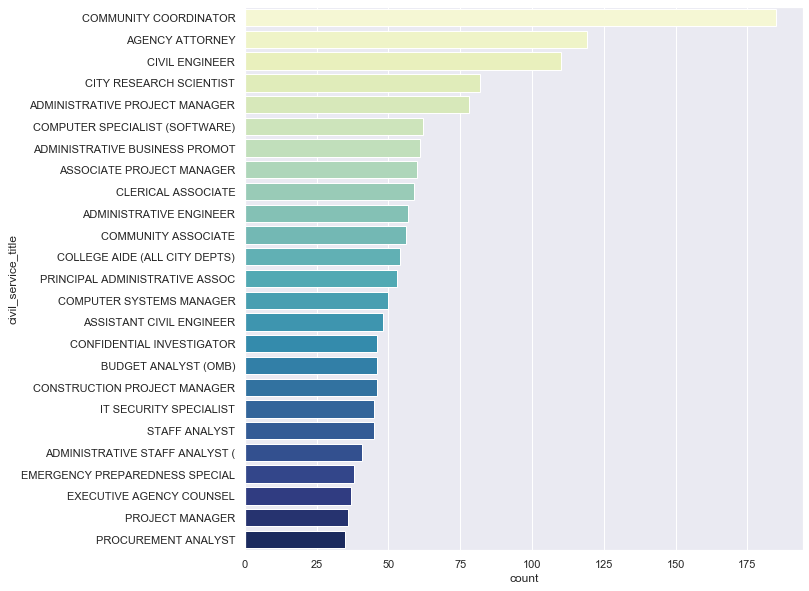

In [14]:
plt.figure(figsize=(10,10))
titles_freq = df.civil_service_title.value_counts()
popular_titles = titles_freq.iloc[:25]
sns.countplot(y="civil_service_title", data=df, order=popular_titles.index, palette=p)

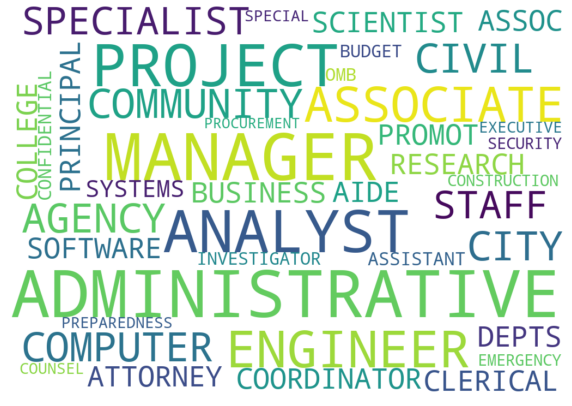

In [15]:
plt.figure(figsize=(10, 8))
plot_wordcloud(' '.join(popular_titles.index.tolist()))

# least popular job titles

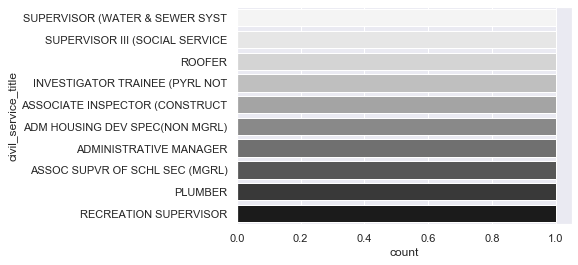

In [16]:
least_popular = titles_freq.iloc[-10:]
sns.countplot(y="civil_service_title", data=df, order=least_popular.index, palette=p3)

# Jobs with highest low salary range(annual)

              civil_service_title  salary_range_low
0       DEPUTY COMMISSIONER (DEP)     214086.000000
1  DEPUTY COMMISIONER(HOMELESS SE     200931.000000
2  DEPUTY COMMISSIONER (HOUSING P     186666.666667
3   DIRECTOR OF RESEARCH & POLICY     185000.000000
4    ASSISTANT COMMISSIONER (DEP)     175000.000000
5  INVESTMENT MANAGER (COMPTROLLE     160000.000000
6  BUDGET ANALYST (OMB)-MANAGERIA     151915.333333
7  ASSISTANT EXECUTIVE DIRECTOR (     145000.000000
8   DIR OF QUALITY & COST CONTROL     145000.000000
9               INSPECTOR GENERAL     140000.000000


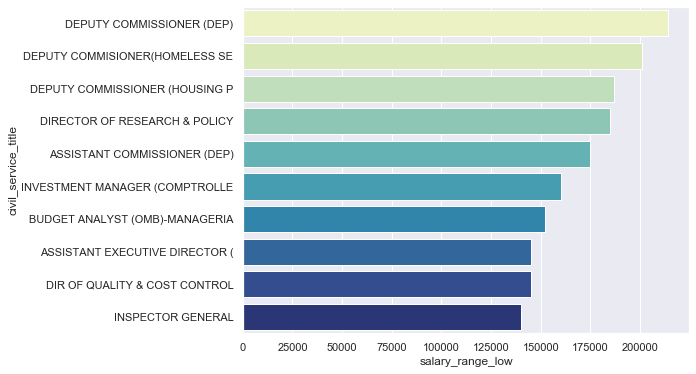

In [17]:
salary_table = df[['civil_service_title', "salary_range_low",'salary_range_high']]
jobs_highest_low_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_low'].mean().nlargest(10)).reset_index()
print(jobs_highest_low_range)
plt.figure(figsize=(8,6))
sns.barplot(y='civil_service_title', x="salary_range_low", data=jobs_highest_low_range, palette=p)

# Jobs with highest high salary range(annual)

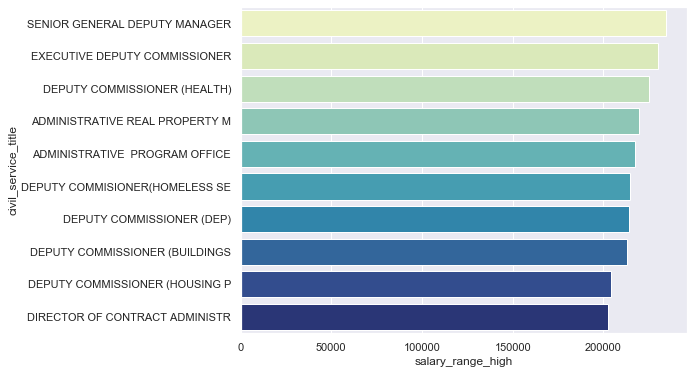

In [18]:
jobs_highest_high_range = pd.DataFrame(salary_table.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range, palette=p)

# Highest paying jobs on hourly basis

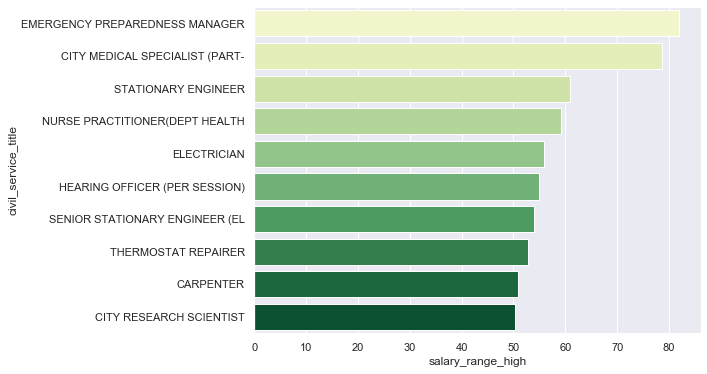

In [19]:
hourly_jobs = df[df.salary_frequency == 'Hourly']
jobs_highest_high_range_hourly = pd.DataFrame(hourly_jobs.groupby(['civil_service_title'])['salary_range_high'].mean().nlargest(10)).reset_index()
plt.figure(figsize=(8, 6))
sns.barplot(y='civil_service_title', x='salary_range_high', data=jobs_highest_high_range_hourly, palette=p2)

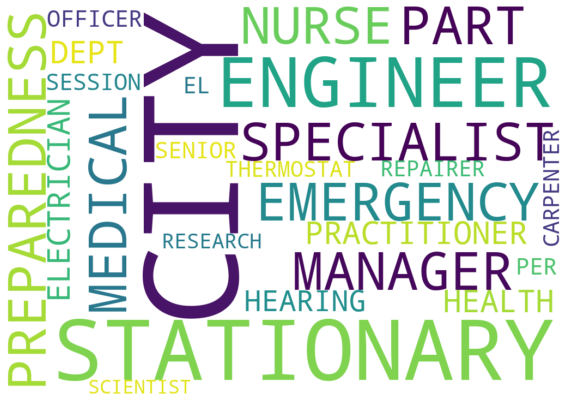

In [20]:
plt.figure(figsize=(10,8))
plot_wordcloud(' '.join(jobs_highest_high_range_hourly['civil_service_title'].tolist()))

# Hourly jobs salary distribution

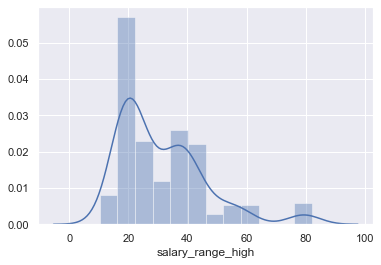

In [21]:
sns.distplot(hourly_jobs.salary_range_high)

# Popular work units

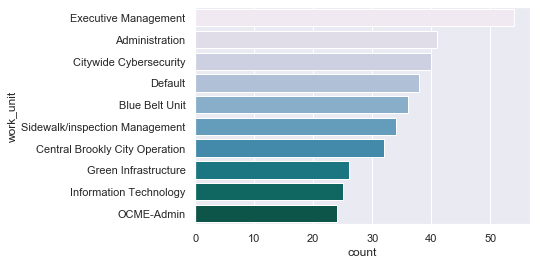

In [22]:
popular_divisions = df.work_unit.value_counts().iloc[:10]
sns.countplot(y='work_unit', data=df, order=popular_divisions.index, palette='PuBuGn')

# Most common keywords in job descriptions

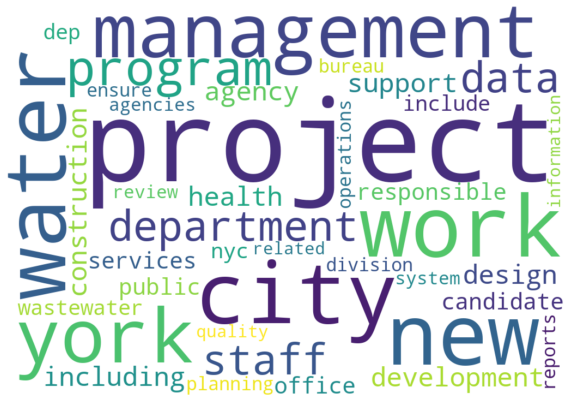

In [23]:
job_description_keywords = []
df.job_description.apply(parse_keywords, l=job_description_keywords)
plt.figure(figsize=(10, 8))
counter = Counter(job_description_keywords)
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))

# Most popular preferred skills per job category

In [24]:
popular_categories = df.job_category.value_counts().iloc[:5]
popular_categories

Engineering, Architecture, & Planning        520
Technology, Data & Innovation                369
Public Safety, Inspections, & Enforcement    219
Legal Affairs                                206
Health                                       185
Name: job_category, dtype: int64

In [25]:
preferred_skills(popular_categories.index[0]).iplot(title='engineering', kind='bar', color='khaki')

In [27]:
preferred_skills(popular_categories.index[1]).iplot(title='Technology', kind='bar', color='deepskyblue')

In [28]:
preferred_skills(popular_categories.index[2]).iplot(title='public safety', kind='bar', color='green')

In [29]:
preferred_skills(popular_categories.index[3]).iplot(title='health', kind='bar', color='powderblue')

In [30]:
preferred_skills(popular_categories.index[4]).iplot(title='legal affairs', kind='bar', color='darkolivegreen')

# Minimum Qualification WordCloud

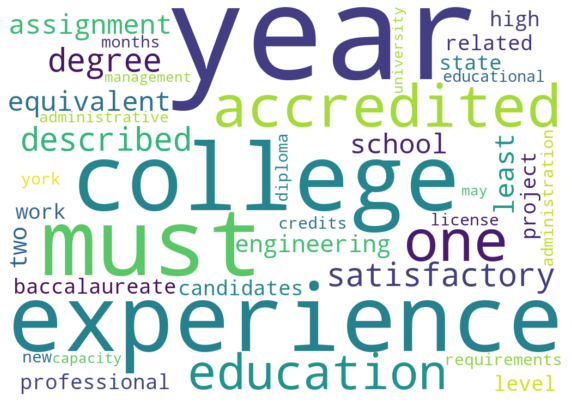

In [36]:
qualification_keywords = []
df.minimum_requirements.dropna().apply(parse_keywords, l=qualification_keywords)
counter = Counter(qualification_keywords)
plt.figure(figsize=(10, 8))
common = [x[0] for x in counter.most_common(40)]
plot_wordcloud(' '.join(common))